In [ ]:
import xarray as xr
import pandas as pd
import numpy as np # ver = 1.22.3
import matplotlib.pyplot as plt
import netCDF4 as nc
import sys
import os
from datetime import date
from clickhouse_driver import Client
import datetime
import itertools


## Creating the DB connection

In [ ]:
client = Client(host='clickhouse',settings={'use_numpy': True})
client.execute('SHOW DATABASES')

In [ ]:
client.execute('DESCRIBE TABLE wow_data.observations')

In [ ]:
officialStationsDF = pd.read_csv('WOW_NL_IsOfficial_KNMIstations.csv',sep=';')

In [ ]:
officialStationsDF

In [ ]:
datesDF = client.query_dataframe('SELECT DISTINCT toDate(CreatedDateTime) FROM wow_data.observations')

In [ ]:
datesDF = datesDF.sort_values(by='toDate_CreatedDateTime_')

In [ ]:
datesDF

In [ ]:
test = client.query_dataframe('SELECT DISTINCT Longitude, Latitude, SiteId FROM wow_data.observations')

In [ ]:
test

In [ ]:

datesList = datesDF['toDate_CreatedDateTime_'].tolist()
datesList = [date.strftime('%Y-%m-%d') for date in datesList]

In [ ]:
datesList

In [ ]:
"""
for date in datesList[1:2]:
    array_from_query = client.execute('SELECT DISTINCT(toStartOfTenMinutes(CreatedDateTime), Longitude, Latitude, SiteId) '\
                                'FROM wow_data.observations WHERE isNotNull(DryBulbTemperature_Celsius) AND toDate(CreatedDateTime)== %(date)s',{"date": date})
    reshapeArray = np.array(array_from_query).reshape((-1,4))
    tempList =[]
    flattened1Level = list(itertools.chain(reshapeArray))
    for i in flattened1Level: 
        dfSingle = pd.DataFrame(np.hstack(i)) 
        tempList.append(dfSingle)
    concatenated = pd.concat(tempList)
    print(len(concatenated.index))
    concatenated.columns =['timeStamp', 'Longitude', 'Latitude', 'SiteId']
    #remove the official stations
    #print(len(tempDF.index))
    wowNoKNMI = concatenated[~concatenated.SiteId.isin(officialStationsDF.SiteId)]
    print(len(wowNoKNMI.index))
    #tempDF[['timeStamp','Longitude', 'Latitude']] = pd.DataFrame(tempDF['tuple_toStartOfTenMinutes_CreatedDateTime___Longitude__Latitude_'].tolist(), index=tempDF.index)
    tempDF2 = wowNoKNMI.groupby(['Longitude', 'Latitude']).size().reset_index().rename(columns={0:'count'})
    n_slots = 6*24 #10-min slots in a day
    tempDF2['score']=tempDF2['count']/n_slots
    #print(tempDF2)
    #print(tempDF)
"""                                  

In [ ]:
#same thing in another way using something more native to pandas
DFlist =[]

for date in datesList[0:200]:
    DF = client.query_dataframe('SELECT DISTINCT(toStartOfTenMinutes(CreatedDateTime), Longitude, Latitude, SiteId) '\
                                'FROM wow_data.observations WHERE isNotNull(DryBulbTemperature_Celsius) AND toDate(CreatedDateTime)== %(date)s',{"date": date})
    DF[['timeStamp','Longitude', 'Latitude','SiteId']] = pd.DataFrame(DF['tuple_toStartOfTenMinutes_CreatedDateTime___Longitude__Latitude__SiteId_'].tolist(), index=DF.index)
    ##remove the official stations
    ##print(len(tempDF.index))
    wowNoKNMI = DF[~DF.SiteId.isin(officialStationsDF.SiteId)]
    #print(len(wowNoKNMI.index))
    ##tempDF[['timeStamp','Longitude', 'Latitude']] = pd.DataFrame(tempDF['tuple_toStartOfTenMinutes_CreatedDateTime___Longitude__Latitude_'].tolist(), index=tempDF.index)
    tempDF2 = wowNoKNMI.groupby(['Longitude', 'Latitude']).size().reset_index().rename(columns={0:'count'})
    n_slots = 6*24 #10-min slots in a day
    tempDF2['score']=tempDF2['count']/n_slots
    DFlist.append(tempDF2)
    ##print(tempDF2)
    ##print(tempDF)
#print(DFlist)

In [ ]:
DFall=pd.concat(DFlist)
avgScores = DFall.groupby(['Latitude','Longitude']).agg({'score':['mean','min','max']})


In [ ]:
avgScores.score['mean']
avgScores.index[0]
lats=avgScores.index.get_level_values('Latitude')
lons=avgScores.index.get_level_values('Longitude')
#plt.scatter(avgScores.Longitude, avgScores.Latitude, s=200, c=avgScores.score['mean'], cmap='gray')

In [ ]:
#pippo = avgScores.reset_index()

In [ ]:
#plt.scatter(pippo.Longitude, pippo.Latitude, s=200, c=pippo.score['mean'], cmap='viridis')

In [73]:
xmin=3
ymin=50.719069
xmax=7.316895
ymax=54

grid_lon = np.linspace(xmin, xmax, 100)
grid_lat = np.linspace(ymin, ymax, 100)


import osmnx as ox
%matplotlib inline
ox.config(log_console=True, use_cache=True)
#ox.__version__



# from some place name, create a GeoDataFrame containing the geometry of the place
country = ox.geocode_to_gdf('Holland, Europe')
print (country)
# save the retrieved data as a shapefile
country.to_file("NL_shapefile")


import geopandas as gpd
NL_Boundary_Shapefile = 'NL_shapefile_irene/NL_WGS84.shp'#'./NL_shapefile/NL_shapefile.shp'
boundary = gpd.read_file(NL_Boundary_Shapefile)
boundary.crs

/opt/conda/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_20866/2222009103.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  country.to_file("NL_shapefile")


                                            geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((3.08016 51.55078, 3.13652 51.5...   53.744395   50.750366   

   bbox_east  bbox_west   place_id  osm_type    osm_id       lat       lon  \
0   7.227499   3.080161  285360560  relation  12728888  52.24765  5.541247   

                        display_name  class    type  importance  
0  European Netherlands, Netherlands  place  region     0.37084  


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

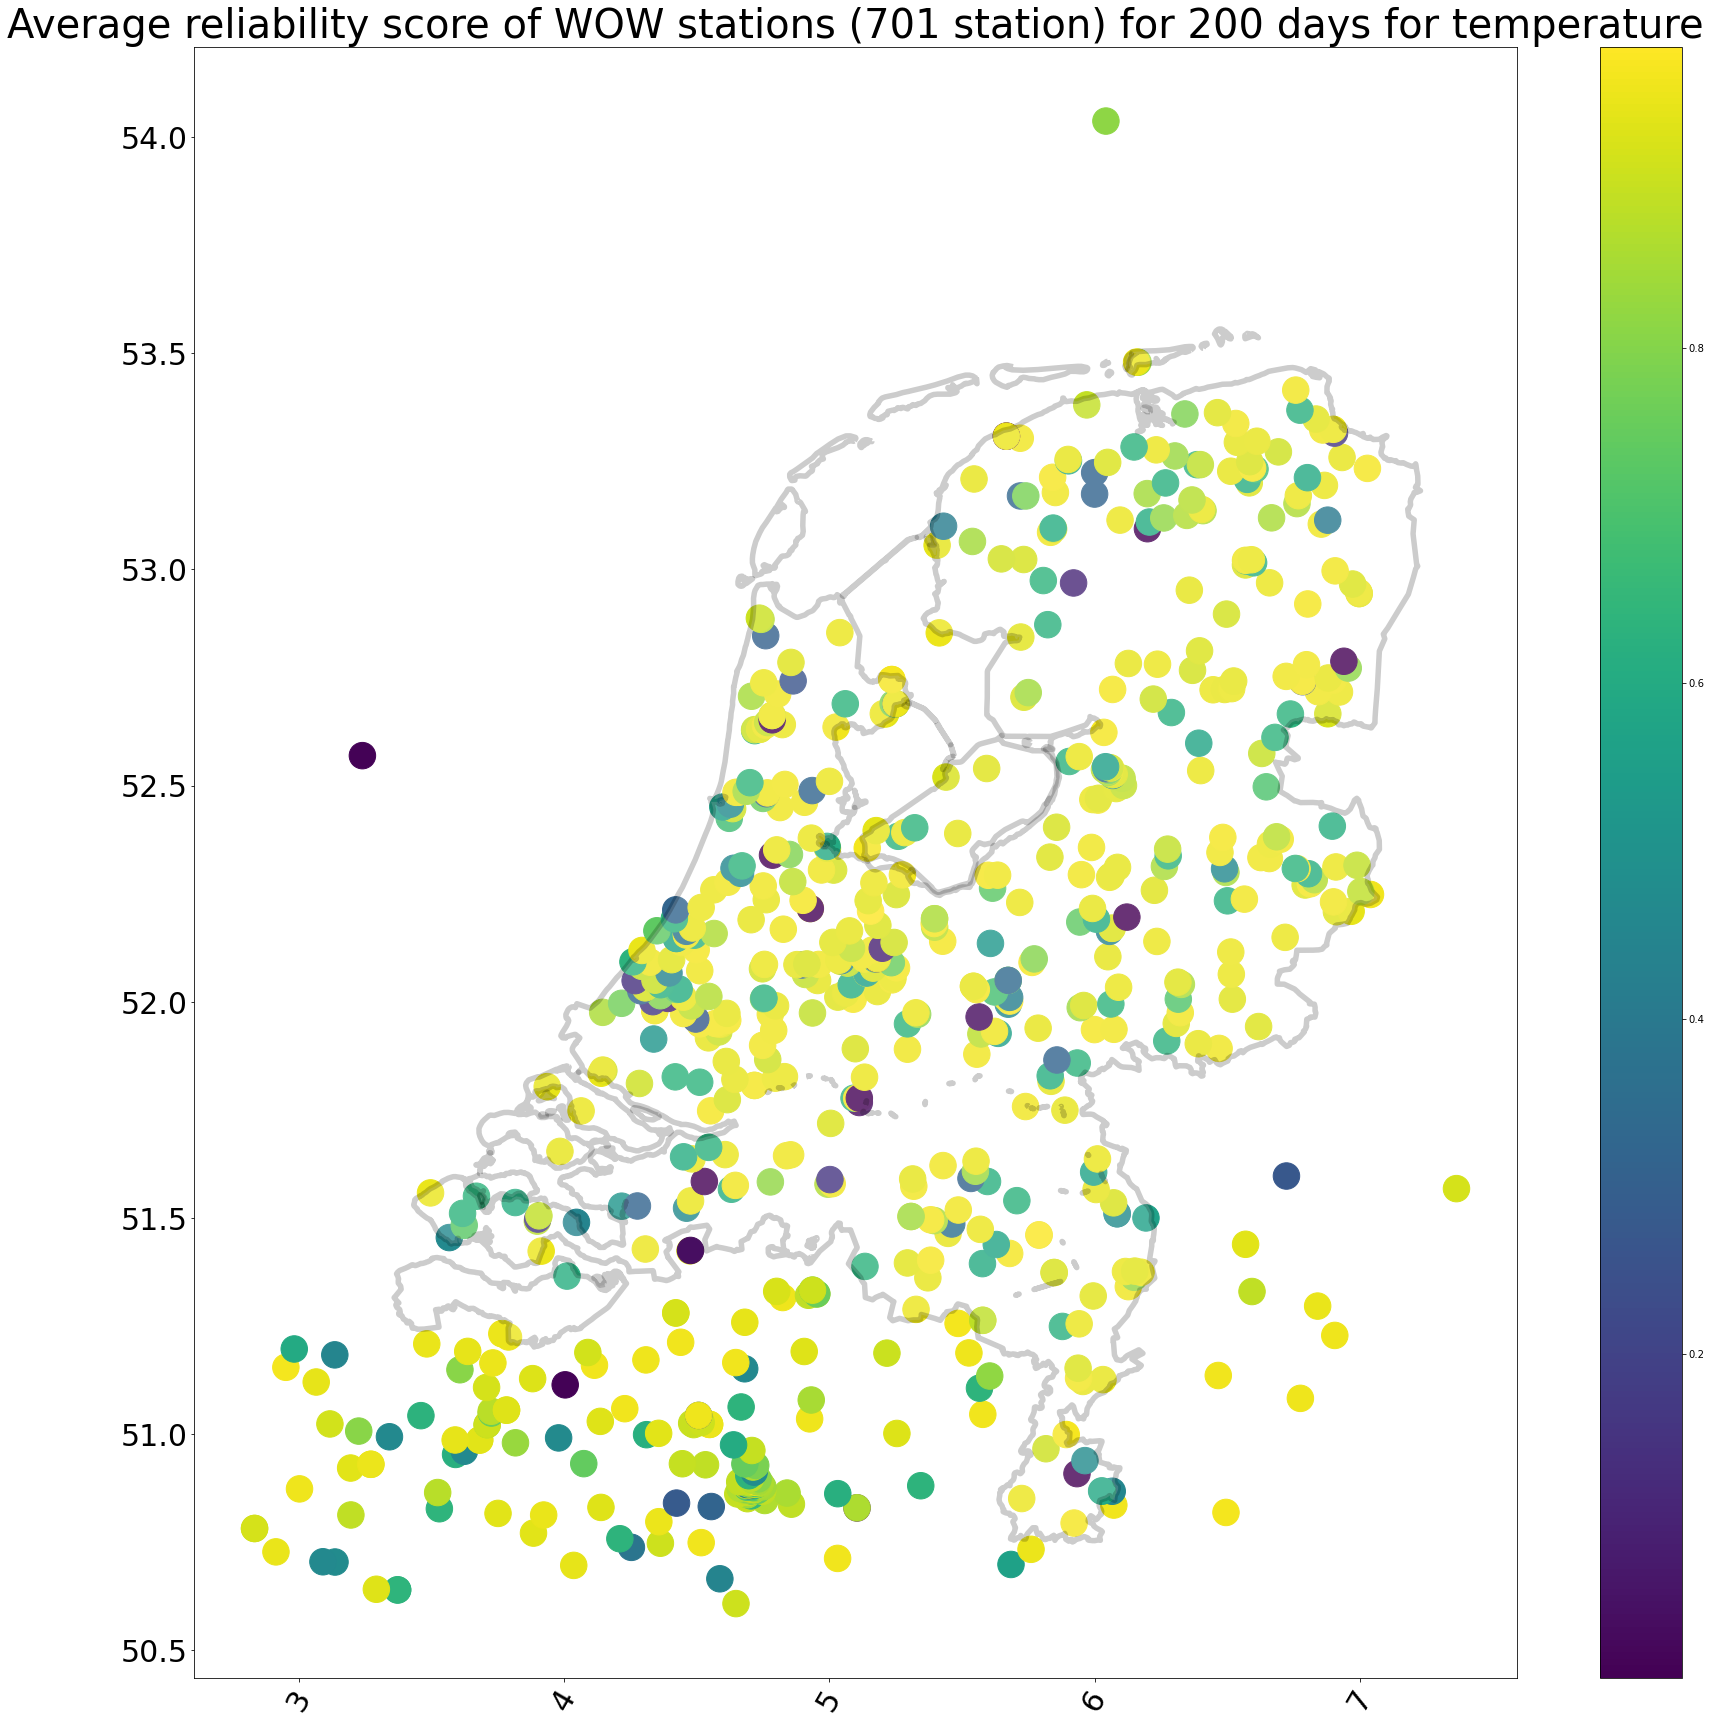

In [74]:
#xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(30,30))


#ax.scatter(lons, lats, s=len(lons), label='Input data')
boundarygeom = boundary.geometry
scores_flatDF=avgScores.reset_index()

scores = scores_flatDF.score['mean'].to_numpy()
#contour = plt.contourf(xintrp, yintrp, z2,len(z2),cmap=plt.cm.jet,alpha = 0.8) 





boundary.plot(ax=ax, color='white', alpha = 0.2, linewidth=5.5, edgecolor='black', zorder = 5)


npts = len(lons)


scat = plt.scatter(lons, lats, c=scores, marker='o',s=npts)

plt.colorbar(scat)

#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)

plt.xticks(fontsize = 30, rotation=60)
plt.yticks(fontsize = 30)

#Tempreture
plt.title('Average reliability score of WOW stations (%d station) for 200 days for temperature' % npts,fontsize = 40)
plt.savefig("task2_WOW_stations_reliab.png")
plt.show()
#ax.plot(grid_lon, grid_lat, label='Predicted values')